In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import os
import pandas as pd
import cv2
import colorsys

# imgroot = '/media/senseable-beast/beast-brain-1/Data/streetviewdata/img/'
imgroot = 'C:/Users/lezhi/Dropbox/thesis/img/'
dataroot = 'C:/Users/lezhi/Dropbox/thesis/data/'

In [2]:
cat_labels = ["Sky", "Building", "Pole", "Unlabelled", "Road", \
        "Pavement", "Tree", "SignSymbol", "Fence", \
        "Car", "Pedestrian", "Bicyclist"]

# def getmask(a, **kwargs):
#     inds = [labels.index(c)+243 for c in kwargs['category']]    
#     return [(ele in inds) for ele in np.nditer(a)]

# much better performance than the commented method...:
'''input a 2D index matrix, return a 2D boolean matrix 
where True means the pixel belongs to one of the specified "category".'''

def getmask(a, **kwargs):    
    inds = [cat_labels.index(c)+243 for c in kwargs['category']] 
    # print np.array(inds)-243
    indicators = np.zeros((a.shape[0], a.shape[1], len(inds))).astype(np.uint8)
    for i in range(len(inds)):
        indicators[:,:,i] = np.array(np.squeeze([a==inds[i]]))
    return np.any(indicators, axis=2)

# color histogram ALL images

In [35]:
def iter_dir(rootdir, dostuff):
    emptyfiles = [] 
    
    citynames = sorted([d for d in os.listdir(rootdir) if os.path.isdir(rootdir)])
    for cityname in citynames[1:2]:   ######################
        # print cityname
        citypath = rootdir + cityname
        imgnames = sorted([f[:-4] for f in os.listdir(citypath) if os.path.isfile(os.path.join(citypath, f))])
        
        lat_lng_dir = np.array([name.replace('_',',').split(',') for name in imgnames])
        df1 = pd.DataFrame(lat_lng_dir, columns=['lat', 'lng', 'dir']).astype(str)############################################
        df1['city'] = cityname
        
        records = []
    
        for i in range(len(imgnames)): # len(imgnames)
            img_filepath = citypath + "/" + imgnames[i] + ".png"
            if os.stat(img_filepath).st_size > 0:                
                image = Image.open(img_filepath) 
                records = records + [dostuff(image)]
            else:
                emptyfiles.append(cityname + "/" + imgnames[i] + ".txt")
        #print records        
        
        df2 = pd.DataFrame(records)
                           #columns=['D1h','D1s','D1v', 'D2h','D2s','D2v', 'Mh','Ms','Mv', "D1hex", 'D2hex', 'Mhex'])
        df = pd.concat([df1, df2], axis=1)
        df.to_csv(dataroot+cityname+'_hist_hsv'+'.csv')
        
    np.savetxt('encode_empty_files'+'.txt', emptyfiles, fmt="%s")
    print str(len(emptyfiles)) + " files are empty"

In [37]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html
def cal_hist(im):
    imarr = np.array(im)    
    mask = (1*getmask(imarr[:,:,3], category=["Building", "SignSymbol", "Pole"])).astype(np.uint8)
    hsv_image = cv2.cvtColor(imarr[:,:,([2,1,0])], cv2.COLOR_BGR2HSV)
    hsv_image[:,:,0] = 256./180. * hsv_image[:,:,0]
    
    if np.sum(mask) < 8840: ###################
        return (np.nan, np.nan)
    else:
        bin_num = 16
        hist = np.zeros(2*bin_num)
        
        for channel in range(2):
            histr = cv2.calcHist([hsv_image[:,:,:2]],[channel],mask,[bin_num],[0,256])
            hist[channel*bin_num : (channel+1)*bin_num] = np.ravel(histr)
        hist = hist / np.sum(mask)

        return tuple(hist)

In [38]:
iter_dir(imgroot, cal_hist)

0 files are empty


## adding labels

In [118]:
labeldf = pd.read_csv(dataroot+'bos_sin_labels.csv', encoding='utf-8', index_col=0)
histdf = pd.read_csv(dataroot+'boston_hist.csv', index_col=0)

In [122]:
histdf = pd.merge(histdf, labeldf[['lat','lng','dir','label']], on=['lat','lng','dir'])

In [123]:
histdf.to_csv(dataroot+'boston_hist2.csv', encoding='utf-8')

# color histogram in one image

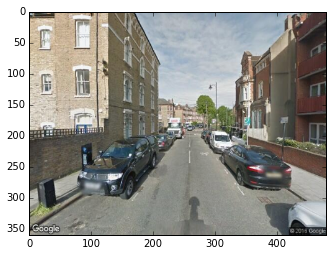

In [3]:
image = Image.open(imgroot+'london/51.46286,-0.12882118455_3.png') #  hongkong/22.278656,114.180662977_0.png
image = np.array(image) # sequence:RGB; cv2 sequence:BGR
plt.imshow(image)

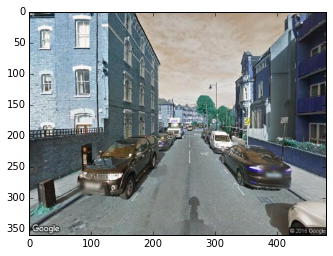

In [4]:
plt.imshow(image[:,:,([2,1,0])])

In [5]:
bins = 16
mask = (1*getmask(image[:,:,3], category=["Building", "SignSymbol", "Pole"])).astype(np.uint8)
hist = np.zeros(3*bins)

In [6]:
hsv_image = cv2.cvtColor(image[:,:,([2,1,0])], cv2.COLOR_BGR2HSV)

In [7]:
hsv_image[:,:,0]

array([[103, 103, 102, ...,   2,   1,   1],
       [103, 102, 100, ...,   2,   2,   1],
       [103, 102, 100, ...,   1,   1,   1],
       ..., 
       [ 22,  21,  21, ..., 102, 103,  99],
       [ 22,  22,  21, ..., 103, 103, 103],
       [ 22,  21,  21, ..., 103, 103, 103]], dtype=uint8)

In [8]:
hsv_image[:,:,0] = 256./180. * hsv_image[:,:,0] # range of h is [0,179]
hsv_image[:,:,0]

array([[146, 146, 145, ...,   2,   1,   1],
       [146, 145, 142, ...,   2,   2,   1],
       [146, 145, 142, ...,   1,   1,   1],
       ..., 
       [ 31,  29,  29, ..., 145, 146, 140],
       [ 31,  31,  29, ..., 146, 146, 146],
       [ 31,  29,  29, ..., 146, 146, 146]], dtype=uint8)

[ 11135.  40657.  14230.   3608.   1079.    538.    703.    663.   1103.
   1239.    485.    193.    169.    183.    242.    994.]
[  6.44600000e+03   1.17830000e+04   1.55950000e+04   1.75460000e+04
   1.10020000e+04   5.72600000e+03   3.59300000e+03   3.01900000e+03
   1.74400000e+03   5.45000000e+02   1.37000000e+02   4.70000000e+01
   1.60000000e+01   1.30000000e+01   5.00000000e+00   4.00000000e+00]
[  8.00000000e+00   1.16300000e+03   2.18300000e+03   5.14100000e+03
   1.04170000e+04   1.25280000e+04   1.04790000e+04   3.88100000e+03
   3.04400000e+03   2.40900000e+03   2.03000000e+03   3.93900000e+03
   9.32600000e+03   6.75700000e+03   2.42800000e+03   1.48800000e+03]


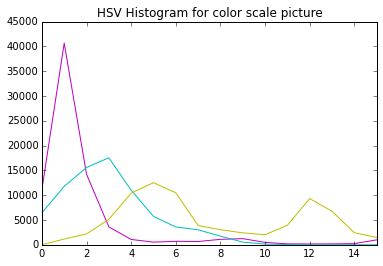

In [10]:
# http://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_image_histogram_calcHist.php
color = ('m','c','y') # represents h,s (no v)
for channel,col in enumerate(color):
    histr = cv2.calcHist([hsv_image[:,:,:3]],[channel],mask,[bins],[0,256])
    print np.ravel(histr)
    hist[channel*bins : (channel+1)*bins] = np.ravel(histr)
    plt.plot(histr,color = col)
    plt.xlim([0,bins-1])
plt.title('HSV Histogram for color scale picture')
plt.show()

In [29]:
hist = hist / np.sum(mask)
hist

array([  1.44196527e-01,   5.26501858e-01,   1.84276298e-01,
         4.67230417e-02,   1.39728830e-02,   6.96701674e-03,
         9.10374121e-03,   8.58574740e-03,   1.42836793e-02,
         1.60448583e-02,   6.28067495e-03,   2.49932013e-03,
         2.18852385e-03,   2.36982168e-03,   3.13386255e-03,
         1.28721462e-02,   8.34747025e-02,   1.52588027e-01,
         2.01952837e-01,   2.27217985e-01,   1.42474197e-01,
         7.41508139e-02,   4.65287940e-02,   3.90955828e-02,
         2.25845301e-02,   7.05766566e-03,   1.77412880e-03,
         6.08642727e-04,   2.07197524e-04,   1.68347988e-04,
         6.47492262e-05,   5.17993810e-05,   1.34158794e-09,
         1.95033346e-07,   3.66085808e-07,   8.62137947e-07,
         1.74691519e-06,   2.10092671e-06,   1.75731250e-06,
         6.50837847e-07,   5.10474210e-07,   4.03985667e-07,
         3.40427939e-07,   6.60564360e-07,   1.56395614e-06,
         1.13313871e-06,   4.07171939e-07,   2.49535356e-07])